# Analisis Sentimen App MyPertamina
- **Nama:** NANTHA SEUTIA
- **Email:** ombakrinai@gmail.com

# Library

In [1]:
# 1. Import library
!pip install google-play-scraper
!pip install Sastrawi

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import re
import nltk
import string
import csv
import requests

# Download NLTK resources BEFORE importing word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Mengimpor pustaka google_play_scraper untuk mengakses ulasan dan informasi aplikasi dari Google Play Store.
from google_play_scraper import app, reviews, Sort, reviews_all

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from io import StringIO
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder

# Library untuk BoW
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np

# Library untuk Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 993.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.0 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Pengumpulan Data

1. Web scraping menggunakan Google Play Scraper.
2. Dataset memiliki minimal 10.000 sampel.
3. Pemberian label kelas sentimen berdasarkan rating (positif, negatif, netral).


In [2]:
# 2. Data Gathering
# Scraping ulasan aplikasi MyPertamina
scrapreview = reviews_all(
    'com.dafturn.mypertamina',  # ID aplikasi
    lang='id',                  # Bahasa ulasan
    country='id',               # Negara
    sort=Sort.MOST_RELEVANT,    # Urutan ulasan
    count=15000                 # Maksimum jumlah ulasan yang diambil
)

# Konversi hasil scraping ke DataFrame
reviews_df = pd.DataFrame(scrapreview)

# Pastikan dataset memiliki minimal 10.000 sampel
if len(reviews_df) >= 10000:
    print("Dataset memenuhi syarat: >= 10.000 sampel.")
else:
    print("Dataset tidak memenuhi syarat.")

# Simpan dataset ke CSV
reviews_df.to_csv('playstore_reviews.csv', index=False, encoding='utf-8')

# Tampilkan datanya
reviews_df.head()

Dataset memenuhi syarat: >= 10.000 sampel.


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,a4994116-a3c1-4a46-9001-1bfdfa10b9a2,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Tadinya sdh bisa registrasi mypertamina dan sd...,1,89,4.6.6,2025-02-01 05:17:32,"Hai, Sobat Zen. Mohon maaf atas ketidaknyamana...",2025-02-01 08:25:03,4.6.6
1,46e5bca6-88fb-4b2a-98aa-03a815d8f7a9,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Makin kesini makin di persulit, mulai dari sud...",1,15,4.6.6,2025-02-08 21:37:29,"Hai, Sobat Julia. Mohon maaf atas ketidaknyama...",2025-02-09 08:37:36,4.6.6
2,b9f04c08-63ed-43d0-9fc1-83b51ccb3415,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Waktu percobaan sukses sampai buat barcode dan...,1,61,4.6.6,2025-01-26 14:15:22,"Hai, Sobat Suharmi. Mohon maaf atas ketidaknya...",2025-01-27 07:20:08,4.6.6
3,81c66434-30e1-4bf4-9ed8-b751eecafef8,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Barcode lebih baik di update perbulan, takutny...",4,4,4.6.6,2025-02-06 07:27:09,None,NaT,4.6.6
4,8bb536dd-4c5c-44a1-844d-c0c0a72c15d2,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Aplikasi yang dibuat sangat bagus, terutama sa...",1,12,4.6.6,2025-02-09 06:02:07,"Hai, Sobat Angga. Mohon maaf atas ketidaknyama...",2025-02-09 08:17:15,4.6.6


In [3]:
# Tampilkan info data
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135000 entries, 0 to 134999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewId              135000 non-null  object        
 1   userName              135000 non-null  object        
 2   userImage             135000 non-null  object        
 3   content               135000 non-null  object        
 4   score                 135000 non-null  int64         
 5   thumbsUpCount         135000 non-null  int64         
 6   reviewCreatedVersion  118854 non-null  object        
 7   at                    135000 non-null  datetime64[ns]
 8   replyContent          13896 non-null   object        
 9   repliedAt             13896 non-null   datetime64[ns]
 10  appVersion            118854 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 11.3+ MB


In [4]:
# Hapus baris yang memiliki nilai yang hilang
clean_review_df = reviews_df.dropna()

# Hapus baris duplikat
clean_review_df = reviews_df.drop_duplicates()

# Tampilkan
clean_review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135000 entries, 0 to 134999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewId              135000 non-null  object        
 1   userName              135000 non-null  object        
 2   userImage             135000 non-null  object        
 3   content               135000 non-null  object        
 4   score                 135000 non-null  int64         
 5   thumbsUpCount         135000 non-null  int64         
 6   reviewCreatedVersion  118854 non-null  object        
 7   at                    135000 non-null  datetime64[ns]
 8   replyContent          13896 non-null   object        
 9   repliedAt             13896 non-null   datetime64[ns]
 10  appVersion            118854 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 11.3+ MB


# Preprocessing Data
1. Cleaning data
2. Case folding (lowercase)
3. Tokenization
4. Stopword Removal
5. Stemming

In [5]:
# 3. Processing Data
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords_en = set(stopwords.words('english'))
    listStopwords.update(listStopwords_en)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [6]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [7]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_review_df['text_clean'] = clean_review_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_review_df['text_casefoldingText'] = clean_review_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_review_df['text_slangwords'] = clean_review_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_review_df['text_tokenizingText'] = clean_review_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_review_df['text_stopword'] = clean_review_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_review_df['text_akhir'] = clean_review_df['text_stopword'].apply(toSentence)

# Pelabelan Data 1

1. Gunakan leksikon data positif dan negatif untuk Bahasa Indonesia
2. Kolom sasaran adalah text_akhir



In [8]:
# 4. Data Labelling
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")

# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

In [9]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    words = text.split()  # Split the text into words!

    for word in words:
        if word in lexicon_positive:
            score = score + lexicon_positive[word]

    for word in words:
        if word in lexicon_negative:
            score = score + lexicon_negative[word]

    polarity = ''
    if score > 0:  # Corrected the condition here (no need for >= 0)
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'  # Explicitly set neutral

    return score, polarity

In [10]:
results = clean_review_df['text_akhir'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_review_df['polarity_score'] = results[0]
clean_review_df['polarity'] = results[1]
print(clean_review_df['polarity'].value_counts())

polarity
negative    76202
positive    30015
neutral     28783
Name: count, dtype: int64


In [11]:
label_encoder = LabelEncoder()

# Fit dan transform kolom 'polarity' menjadi numerik
clean_review_df['label'] = label_encoder.fit_transform(clean_review_df['polarity'])

# Tampilkan mapping label
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Tampilkan 5 baris teratas dengan label
clean_review_df[['polarity', 'label']].head()

{'negative': 0, 'neutral': 1, 'positive': 2}


,polarity,label
0,negative,0
1,negative,0
2,negative,0
3,negative,0
4,negative,0


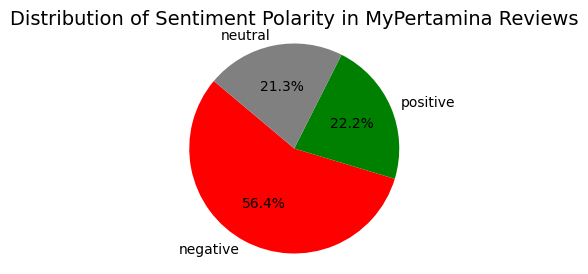

In [12]:
# Calculate value counts of 'polarity' column
polarity_counts = clean_review_df['polarity'].value_counts()

# Create a DataFrame from the value counts (optional, but good practice)
df = pd.DataFrame({'polarity': polarity_counts.index, 'count': polarity_counts.values})

# Plotting the pie chart
plt.figure(figsize=(4, 3))  # Adjust figure size for better readability

# Define colors
colors = ['red', 'green', 'gray']

# Create the pie chart
plt.pie(df['count'], labels=df['polarity'], colors=colors,
        autopct='%1.1f%%', startangle=140)

# Add a title
plt.title('Distribution of Sentiment Polarity in MyPertamina Reviews', fontsize=14)

# Ensure the circle's proportion
plt.axis('equal')

# Show the plot
plt.show()

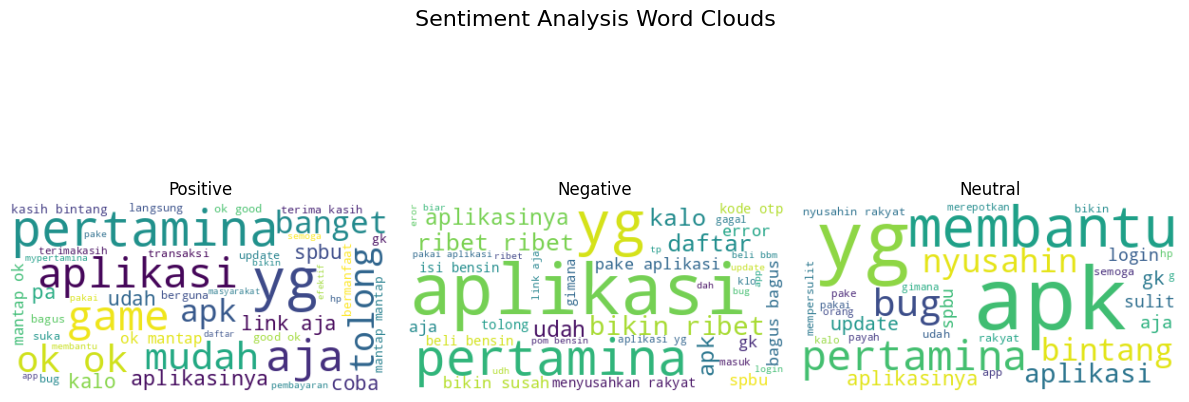

In [13]:
# Function to generate word cloud (no display inside the function)
def generate_wordcloud(text):
    wordcloud = WordCloud(width=400, height=200,  # Smaller size
                          background_color='white',
                          max_words=100,  # Fewer words for clarity
                          min_font_size=8).generate(' '.join(text))
    return wordcloud


# Separate text by polarity
positive_text = clean_review_df[clean_review_df['polarity'] == 'positive']['text_akhir']
negative_text = clean_review_df[clean_review_df['polarity'] == 'negative']['text_akhir']
neutral_text = clean_review_df[clean_review_df['polarity'] == 'neutral']['text_akhir']

# Generate word clouds
positive_wc = generate_wordcloud(positive_text)
negative_wc = generate_wordcloud(negative_text)
neutral_wc = generate_wordcloud(neutral_text)

# Create a figure with subplots
fig = plt.figure(figsize=(12, 6))  # Adjust figure size

# Create a gridspec layout for better spacing
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])  # 1 row, 3 columns

# Plotting the word clouds
ax1 = plt.subplot(gs[0])
ax1.imshow(positive_wc, interpolation='bilinear')
ax1.set_title('Positive', fontsize=12)
ax1.axis("off")

ax2 = plt.subplot(gs[1])
ax2.imshow(negative_wc, interpolation='bilinear')
ax2.set_title('Negative', fontsize=12)
ax2.axis("off")

ax3 = plt.subplot(gs[2])
ax3.imshow(neutral_wc, interpolation='bilinear')
ax3.set_title('Neutral', fontsize=12)
ax3.axis("off")

plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.suptitle("Sentiment Analysis Word Clouds", fontsize=16)  # Overall title
plt.show()

# Pelatihan Machine Learning
1. Ekstraksi Fitur: Term Frequency-Inverse Document Frequency (TF-IDF)

Akurasi Model (Support Vector Machine): 0.948

Laporan Klasifikasi (SVM):
               precision    recall  f1-score   support

           0       0.96      0.97      0.97     15219
           1       0.91      0.91      0.91      5741
           2       0.95      0.92      0.94      6040

    accuracy                           0.95     27000
   macro avg       0.94      0.93      0.94     27000
weighted avg       0.95      0.95      0.95     27000

Akurasi Model (RandomForestClassifier): 0.9112962962962963

Laporan Klasifikasi (Random Forest):
               precision    recall  f1-score   support

           0       0.89      0.97      0.93     15219
           1       0.94      0.89      0.91      5741
           2       0.94      0.77      0.85      6040

    accuracy                           0.91     27000
   macro avg       0.92      0.88      0.90     27000
weighted avg       0.91      0.91      0.91     27000



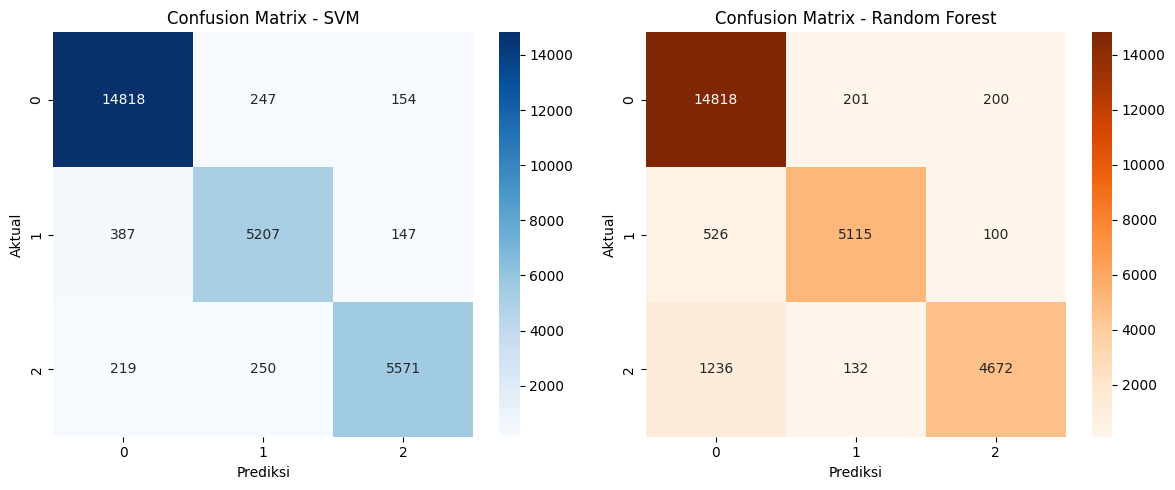

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Menggunakan TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_review_df['text_akhir'])
y = clean_review_df['label']

# 2. Membagi Dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Model 1: Support Vector Machine
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# 4. Model 2: RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=110, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# 5. Evaluasi Model SVM
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Akurasi Model (Support Vector Machine):", accuracy_svm)
print("\nLaporan Klasifikasi (SVM):\n", classification_report(y_test, y_pred_svm))

# 6. Evaluasi Model RandomForest
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Akurasi Model (RandomForestClassifier):", accuracy_rf)
print("\nLaporan Klasifikasi (Random Forest):\n", classification_report(y_test, y_pred_rf))

# 7. Visualisasi Confusion Matrix
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix - SVM")

plt.subplot(1, 2, 2)
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges')
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix - Random Forest")

plt.tight_layout()
plt.show()

Kesimpulan :
1. Multinomial Naive Bayes (MNB)
    * Cenderung memiliki recall tinggi untuk kelas 0 (negative) tetapi sangat rendah pada kelas 1 (positive).
    * F1-score untuk kelas 1 hanya 0.41, yang menunjukkan kesulitan model dalam mengenali kelas ini.
2. RandomForestClassifier (RFC)
    * Precision dan recall lebih seimbang di semua kelas, terutama kelas 1 yang sebelumnya sulit dikenali oleh MNB.
    * F1-score lebih tinggi di semua kelas, yang berarti model lebih efektif dalam menangkap pola dari data.

RandomForestClassifier lebih unggul dibandingkan Multinomial Naive Bayes dalam hal akurasi dan keseimbangan prediksi antar kelas.

✅ RFC lebih mampu menangani ketidakseimbangan data, terutama dalam mengenali kelas positive (1) yang sebelumnya sulit dideteksi oleh Naive Bayes.

✅ Jika ingin model yang lebih akurat dan stabil, RandomForestClassifier adalah pilihan yang lebih baik dalam kasus ini.

Saran

Bisa mencoba hyperparameter tuning untuk RFC, seperti n_estimators, max_depth, dan min_samples_split, agar performa lebih optimal.
Menggunakan teknik balancing tambahan seperti SMOTE jika ingin meningkatkan recall pada kelas positif lebih lanjut.

2. Ekstraksi Fitur: Word2Vec

Akurasi Model (RandomForestClassifier): 0.8407407407407408

Laporan Klasifikasi (Random Forest):
               precision    recall  f1-score   support

           0       0.81      0.96      0.88     15219
           1       0.92      0.74      0.82      5741
           2       0.87      0.64      0.73      6040

    accuracy                           0.84     27000
   macro avg       0.87      0.78      0.81     27000
weighted avg       0.85      0.84      0.84     27000



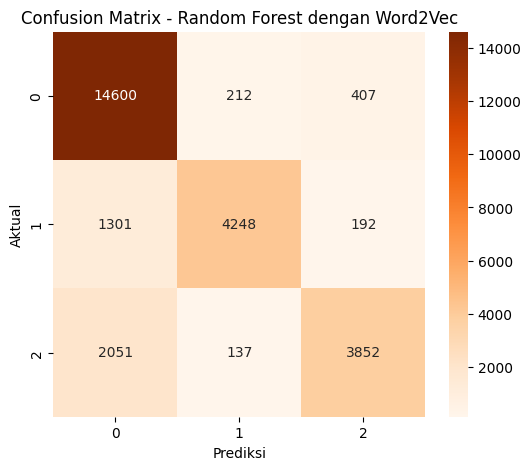

In [15]:
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Menggunakan Word2Vec untuk ekstraksi fitur
sentences = [text.split() for text in clean_review_df['text_akhir']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

def get_word2vec_features(text):
    words = text.split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(word_vectors) == 0:
        return np.zeros(110)
    return np.mean(word_vectors, axis=0)

X = np.array([get_word2vec_features(text) for text in clean_review_df['text_akhir']])
y = clean_review_df['label']

# 2. Membagi Dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Model: RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# 4. Evaluasi Model RandomForest
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Akurasi Model (RandomForestClassifier):", accuracy_rf)
print("\nLaporan Klasifikasi (Random Forest):\n", classification_report(y_test, y_pred_rf))

# 5. Visualisasi Confusion Matrix
plt.figure(figsize=(6, 5))
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges')
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix - Random Forest dengan Word2Vec")
plt.show()